学习选择最佳策略：策略梯度法

策略的$\epsilon$贪婪算法，以概率$\epsilon$选择随机动作，以概率$1-\epsilon$选择当前策略下最优的动作（最高Q值对应的动作）。

随机策略梯度：在随机策略梯度法中，神经网络的输出是一个代表概率分布的动作向量。策略函数接收一个状态并返回动作的概率分布。之所以说“随机”，是因为返回的是动作的概率分布，而不是确定的单一动作。我们要遵从的策略是从这个概率分布中选择一个动作，这意味着，即使智能体两次处于相同的状态，也有可能采取不同的动作

确定性策略梯度（DPG）接收一个状态并返回一个要采取的具体动作，随机策略则返回动作的概率分布。确定性策略函数对离散动作集的输出是离散值。  

In [3]:
import numpy as np
import torch
import gymnasium as gym
from matplotlib import pyplot as plt

In [4]:
#计算输入数组 x 的滑动平均值
def running_mean(x, N=50):   #N为滑动窗口大小
    #创建卷积核，这里用的是全1的卷积核
    kernel = np.ones(N)
    #计算卷积长度，即滑动平均数组的长度
    conv_len = x.shape[0]-N
    #初始化数组
    y = np.zeros(conv_len)
    #循环遍历每个可能的滑动窗口位置
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]  #计算 kernel 和 x[i:i+N] 的点积（即加权和）
        y[i] /= N
    return y

In [13]:
env = gym.make("CartPole-v1")

In [16]:
#import gym
#from gym import envs
#envs.registry

创建策略网络：创建并初始化一个充当策略网络的神经网络，它将接收状态向量作为输入，并生成一个（离散）在可能动作上的概率分布。

In [17]:
import numpy as np
import torch

l1 = 4   #输入数据长度为 4
l2 = 150   #中间层产生一个长度为 150 的向量
l3 = 2    #输出是一个用于向左、向右动作的长度为 2 的向量

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.Softmax(dim=0)     #输出是一个softmax概率分布
)

learning_rate = 0.009
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


使智能体与环境交互：智能体接收状态并以一定概率采取动作 a。更具体点，状态被输入策略网络，然后由策略网络根据其当前参数和状态生成动作的概率分布。

注：大写字母A表示给定状态下所有可能动作的集合，小写字母a表示从A中选取的具体动作。

策略网络可能会以向量形式返回一个离散的概率分布

In [18]:
state1 = env.reset()  #reset方法用于初始化环境并返回第一个状态
pred = model(torch.from_numpy(state1[0]))   #调用策略网络模型产生预测的动作概率
action = np.random.choice(np.array([0,1]), p=pred.data.numpy())  #从策略网络产生的概率分布中抽样一个动作
state2, reward, done, info, _ = env.step(action)   #采取动作并获得新的状态和奖励。info变量由环境生成，但与环境无关

训练模型：通过更新参数最小化目标（损失）函数来训练策略网络，包括三个步骤

1、计算每个时间不中实际采取动作的概率，即计算动作的概率

2、将概率乘贴现奖励（奖励的总和），即计算未来奖励。

3、使用这个概率加权的奖励来反向传播并最小化损失，即计算损失函数以及进行反向传播

In [19]:
def discount_rewards(rewards, gamma=0.99):
    lenr = len(rewards)
    #torch.pow 函数可以计算一个张量中每个元素的指定次幂，它支持多种输入形式，
    #gamma的torch.arange(lenr).float() 次幂
    disc_return = torch.pow(gamma,torch.arange(lenr).float()) * rewards #计算指数衰减奖励
    disc_return /= disc_return.max() #将奖励归一化到[0,1]，以提高数值稳定性
    return disc_return

进行反向传播：既然目标函数包含了所有变量，就可以通过计算损失并进行反向传播来调整参数

In [20]:
def loss_fn(preds, r): #损失函数期望一个对所采取动作的动作概率数组和贴现奖励
    #计算概率的对数，乘贴现奖励，对其求和，然后对结果取反
    return -1 * torch.sum(r * torch.log(preds)) 

完整的训练循环：初始化、收集经验、计算这些经验的损失、反向传播。代码定义了REINFORCE智能体的完整训练循环。

开始训练一个轮次，用策略网络采取动作，并记录观察到的状态和动作。一旦跳出一个轮次，就必须重新计算预测概率用于损失函数。由于我们将每个轮次中的所有转换记录为一个元组列表，因此一旦离开了该轮次，我们就可以将每个转换的每个组件（状态、动作、奖励）分离为单独的张量，以便每次训练一批数据

In [21]:
MAX_DUR = 200  #每一轮（episode）中允许的最大时间步数
MAX_EPISODES = 500   #总的训练轮数
gamma = 0.99
score = [] #记录训练期间轮次长度的列表，即智能体在该轮中存活的时间步数
expectation = 0.0
for episode in range(MAX_EPISODES):
    curr_state = env.reset()[0]
    done = False   #用于标记当前轮次是否结束
    transitions = [] #用于存储当前轮次中智能体与环境交互的所有经验数据，包括状态、动作和奖励（但我们忽略奖励）
    
    for t in range(MAX_DUR): 
        #将当前状态转换为 PyTorch 张量并输入到模型中，得到动作概率分布。
        #torch.from_numpy()是PyTorch中的一个函数，用于将NumPy数组转换为PyTorch张量（Tensor）
        act_prob = model(torch.from_numpy(curr_state).float()) #获取动作概率
        action = np.random.choice(np.array([0,1]), p=act_prob.data.numpy()) #随机选择一个动作
        #保存当前状态的上一个状态
        prev_state = curr_state
        curr_state, _, done, _, info = env.step(action) #在环境中采取动作
        #将上一个状态、动作和当前时间步作为奖励存储到 transitions 列表中。
        transitions.append((prev_state, action, t+1)) #存储这个转换
        if done: #如果游戏失败，则退出循环
            break

    #计算当前轮次的长度
    ep_len = len(transitions) #存储轮次时长
    #将当前轮次的长度添加到 score 列表中
    score.append(ep_len)
    reward_batch = torch.Tensor([r for (s,a,r) in transitions]).flip(dims=(0,)) #单个张量中收集轮次中的所有奖励
    disc_returns = discount_rewards(reward_batch) #计算贴现奖励
    state_batch = torch.Tensor([s for (s,a,r) in transitions]) #在单个张量中收集轮次中的状态
    action_batch = torch.Tensor([a for (s,a,r) in transitions]) #在单个张量中收集轮次中的动作
    pred_batch = model(state_batch) #重新计算轮次中的每个状态的动作概率
    prob_batch = pred_batch.gather(dim=1,index=action_batch.long().view(-1,1)).squeeze() #取与实际采取动作关联的动作概率的子集
    loss = loss_fn(prob_batch, disc_returns)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

/var/folders/wt/t4q1f61n40x0vm0746z9p1hh0000gn/T/ipykernel_25683/347776717.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  state_batch = torch.Tensor([s for (s,a,r) in transitions]) #L


In [22]:
#np.array()函数传递一个列表（或列表的列表，或其他可迭代对象）来创建一个数组
score = np.array(score)
avg_score = running_mean(score, 50)

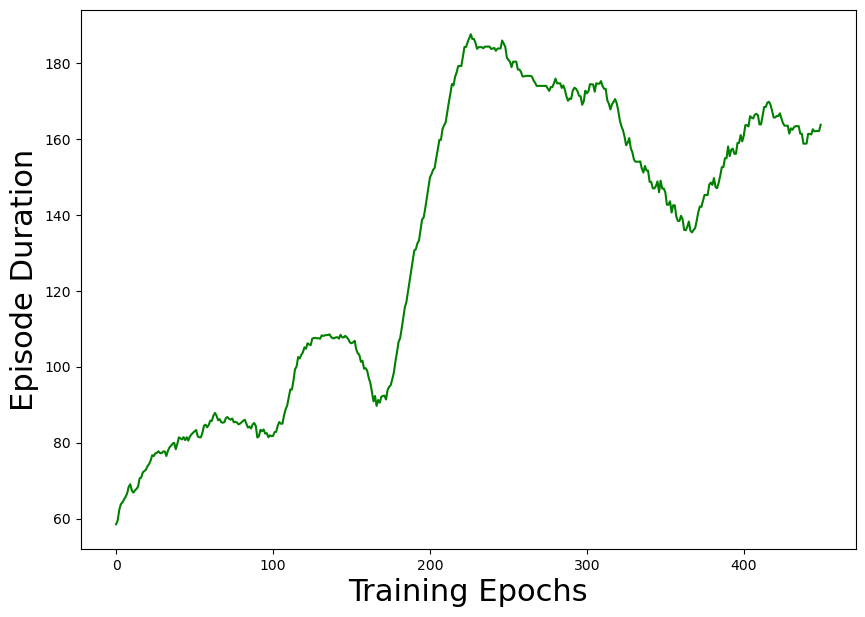

In [35]:
plt.figure(figsize=(10,7))
plt.ylabel("Episode Duration",fontsize=22)
plt.xlabel("Training Epochs",fontsize=22)
plt.plot(avg_score, color='green')

In [24]:
score = []  #初始化一个空列表 score，用于存储每次游戏中智能体坚持的时间步数
games = 100  #设置要进行的游戏次数为 100 次
done = False
#env.reset() 通常会返回一个包含初始状态等信息的元组，这里取元组的第一个元素作为初始状态。
state1 = env.reset()[0] #重置环境，获取环境的初始状态
for i in range(games):
    t=0  #初始化当前游戏的时间步数为 0
    while not done: #进入一个内部循环，只要当前游戏没有结束，就持续执行
        #检查当前状态state1是否为元组类型
        #是则取元组的第一个元素作为新的状态。这可能因为环境的reset或step方法返回的状态有时会封装在元组中
        if type(state1) is tuple:
            state1 = state1[0]
        #将当前状态 state1 转换为 PyTorch 张量，并输入到模型 model 中，得到动作的概率分布 pred。
        pred = model(torch.from_numpy(state1).float()) 
        #根据模型输出的动作概率分布 pred，从 [0, 1] 中随机选择一个动作。
        #参数p指定了每个元素被选中的概率。在这个例子中，p=pred.data.numpy()提供了选择每个元素的概率。
        #第一个参数np.array([0, 1])指定了可以选择的元素集合
        #np.random.choice是NumPy库中的一个函数，用于从给定的一维数组中随机抽取元素
        action = np.random.choice(np.array([0,1]), p=pred.data.numpy()) 
        #在环境中执行选择的动作action，并获取新的状态state2、奖励reward、游戏是否结束的标志done以及其他信息info
        state2, reward, done, _, info = env.step(action) 
        state1 = state2
        if(type(state1) == 'tuple'):
            state1 = state2[0]
        
        t += 1  #时间步数加 1
        #当前时间步数超过了最大允许时间步数 MAX_DUR，则跳出内部循环，结束当前游戏。
        if t > MAX_DUR: 
            break;
    state1 = env.reset() #重置环境，为下一次游戏做准备。
    done = False
    score.append(t)
score = np.array(score)  #将当前游戏中智能体坚持的时间步数 t 添加到 score 列表中

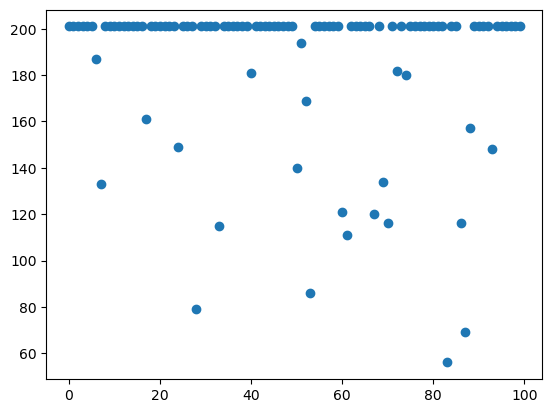

In [25]:
plt.scatter(np.arange(score.shape[0]),score)
#使用score数组的长度生成一个从0开始的整数序列作为x轴坐标
#使用score数组本身作为y轴坐标。

REINFORCE是策略梯度法的一种简单实现，他的本质是最大化动作概率乘采取该动作后观察到的奖励值，这样每个动作的概率都会根据观察到的奖励大小进行调整